# 2 - Training and evaluating our models

Mini-project for the 'Machine learning for NLP' course at ENSAE - May 2025

Paul Dupire and Floriane Zanella

## Installing the libraries, and loading the data

In [ ]:
# Installing the required libraries
#!pip install datasets scikit-learn pandas tqdm -q
#!pip install seaborn
#!pip install transformers[torch]
#!pip install accelerate
#!pip install wandb
#!pip install lime
#!pip install optuna

In [1]:
# Necessary packages
import pandas as pd
import torch
import os
from datasets import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import lime
import optuna
from transformers import Trainer, TrainingArguments, TrainerCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import accelerate
import numpy as np
import wandb
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import gc
import joblib
from collections import Counter

2025-05-03 20:20:17.983562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746303618.168406      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746303618.219669      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Loading the two datasets we created in the notebook 1 - Retrieving, formating and exploring the data
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

In [42]:
test_df.head(10)

,id_review,review,rating,label,url,id_movie
6868,4932,"When I was a kid, I loved ""Tiny Toons"". I espe...",10,1,https://www.imdb.com/title/tt0105598/,tt0105598
24016,9115,"The setup for ""Nature of the Beast"" is ingenio...",3,0,https://www.imdb.com/title/tt0113939/,tt0113939
9668,7452,I do not have much to say than this is a great...,10,1,https://www.imdb.com/title/tt0385700/,tt0385700
13640,11026,Extremely formulaic with cosmic-sized logic ho...,3,0,https://www.imdb.com/title/tt0031602/,tt0031602
14018,11367,I actually liked certain things about this gam...,4,0,https://www.imdb.com/title/tt0232532/,tt0232532
7488,5490,"I was watching the Perfect Storm, and thought ...",9,1,https://www.imdb.com/title/tt0107206/,tt0107206
5804,3975,"The best thing from the American Pie ""bakery.""...",10,1,https://www.imdb.com/title/tt0384793/,tt0384793
12909,10369,A severe backwards step for the puppets in thi...,4,0,https://www.imdb.com/title/tt0107899/,tt0107899
3386,1799,"""Valley Girl"" launched Nicolas Cage's career a...",9,1,https://www.imdb.com/title/tt0086525/,tt0086525
9567,7361,I cannot believe I enjoyed this as much as I d...,8,1,https://www.imdb.com/title/tt0115813/,tt0115813


In [4]:
# texts and rating/label will be integrated to our scored dataframes later
all_texts = test_df["review"].tolist()
all_true_labels = test_df["label"].tolist()
all_ratings = test_df["rating"].tolist()

In [5]:
# We will work with the DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Splitting train_df into train and eval sets, ensuring that the classes are balanced
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    train_df["review"].tolist(),
    train_df["label"].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=train_df["label"]
)

# Creating Dataset objects, by converting the data to HuggingFace Dataset format
train_dataset = Dataset.from_dict({"review": train_texts, "label": train_labels})
eval_dataset = Dataset.from_dict({"review": eval_texts, "label": eval_labels})
test_dataset = Dataset.from_pandas(test_df)

# PART I : Training and evaluating a baseline DistilBERT model

In [14]:
# Tokenization using DistilBERT, our baseline function
def tokenize(batch, type_review = 'review'):
    tokenized = tokenizer(batch[type_review], padding="max_length", truncation=True, max_length=512)
    tokenized["num_tokens"] = [len(tokenizer.tokenize(t)) for t in batch[type_review]]
    return tokenized

In [15]:
train_tokenized = train_dataset.map(tokenize, batched=True)
eval_tokenized = eval_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [16]:
# Setting the format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])

### Early experimentation on hyperparameters : testing several (learning rate, batch size) configurations

In [78]:
# We made trials of training, to explore the effect of changing the learning rate and batch size (especially on the computation time)
# For all the model trainings, we use the Trainer API from HuggingFace
def objective(trial):
    # Reinitializing the model for each trial
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    
    # Suggesting hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate',1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [8,16,32])
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="./bert_results",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,  
        num_train_epochs=2,
        eval_steps = 500,
        logging_steps= 500, 
        logging_strategy="steps",
        eval_strategy = 'steps',
        logging_dir="./logs", 
        save_strategy="no"
    )
    
    # Trainer initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=eval_tokenized,
        compute_metrics=compute_metrics
    )
    
    # Train and return validation loss
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results['eval_loss']

# Optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=4)
print(study.best_params)

[I 2025-05-03 14:40:04,273] A new study created in memory with name: no-name-87fbdfa2-f1c7-4ef0-a15a-82e123730309
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2760029119.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-5, 5e-5)


Step,Training Loss,Validation Loss,Accuracy
500,0.298200,0.208641,0.916400
1000,0.194000,0.194577,0.928000


[I 2025-05-03 15:05:49,632] Trial 0 finished with value: 0.19452570378780365 and parameters: {'learning_rate': 1.162024247924075e-05, 'batch_size': 32}. Best is trial 0 with value: 0.19452570378780365.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2760029119.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-5, 5e-5)


Step,Training Loss,Validation Loss,Accuracy
500,0.331200,0.219734,0.912800
1000,0.254300,0.195072,0.920800
1500,0.200400,0.241963,0.934800
2000,0.136900,0.220827,0.933600
2500,0.138600,0.213674,0.936800


[I 2025-05-03 15:31:36,557] Trial 1 finished with value: 0.218826025724411 and parameters: {'learning_rate': 3.356714022207949e-05, 'batch_size': 16}. Best is trial 0 with value: 0.19452570378780365.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2760029119.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-5, 5e-5)


Step,Training Loss,Validation Loss,Accuracy
500,0.296100,0.207679,0.918400
1000,0.188200,0.190332,0.928000


[I 2025-05-03 15:57:22,935] Trial 2 finished with value: 0.19224072992801666 and parameters: {'learning_rate': 1.3798589791089372e-05, 'batch_size': 32}. Best is trial 2 with value: 0.19224072992801666.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2760029119.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-5, 5e-5)


Step,Training Loss,Validation Loss,Accuracy
500,0.282300,0.198744,0.922400
1000,0.162900,0.197033,0.931600


[I 2025-05-03 16:23:08,988] Trial 3 finished with value: 0.19289347529411316 and parameters: {'learning_rate': 3.7820144850704565e-05, 'batch_size': 32}. Best is trial 2 with value: 0.19224072992801666.


{'learning_rate': 1.3798589791089372e-05, 'batch_size': 32}


In [17]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# We use the Trainer API from HuggingFace, with our baseline parameters that will be identical for our three models

# Custom compute metrics function which will return the accuracy on validation set 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate= 5e-5,
    num_train_epochs=2,  
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    logging_steps= 500, 
    eval_steps = 500,
    eval_strategy = 'steps',
    logging_strategy="steps",
    logging_dir="./logs", 
    save_strategy="no"
)

In [19]:
# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,  
    compute_metrics=compute_metrics)

In [20]:
# Fine-Tuning our DistilBERT
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paul-d10 (paul-d10-ensae-alumni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Accuracy
500,0.330300,0.275693,0.882800
1000,0.249800,0.212204,0.916400
1500,0.211400,0.377359,0.910000
2000,0.134100,0.265565,0.926000
2500,0.129300,0.234068,0.931600


TrainOutput(global_step=2814, training_loss=0.1998424313131087, metrics={'train_runtime': 1534.1129, 'train_samples_per_second': 29.333, 'train_steps_per_second': 1.834, 'total_flos': 5961032939520000.0, 'train_loss': 0.1998424313131087, 'epoch': 2.0})

In [21]:
# Saving the model after training
model_save_path = "./imdb_sentiment_model_1"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Saving training arguments using the to_json_string method
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model_1


In [24]:
# Function to evaluate the model on the test set and return predicted labels and positive class scores
def test_predictions(model_used, tokenized_test_set, batch_size=16):

    model.eval()

    # DataLoader for batching the test data
    test_loader = DataLoader(tokenized_test_set, batch_size=batch_size)

    # Lists to store the predictions and scores
    all_preds = []
    all_scores = []
    all_token_counts = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Collecting the predictions and scores
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(probs[:, 1].cpu().numpy())  # positive class score
            all_token_counts.extend(batch["num_tokens"].cpu().numpy())  # we get the original token count for further analysis

    return all_preds, all_scores, all_token_counts

In [44]:
# Creating a final scored dataframe and saving it
all_preds, all_scores, all_token_counts = test_predictions(model, test_tokenized)

scored_df1 = pd.DataFrame({
    "review": all_texts,
    "true_label": all_true_labels,
    "rating": all_ratings,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts
}, index=test_df.index)

scored_df1["rating"] = scored_df1["rating"].astype(int)

# Adding a 'confidence' column
scored_df1["confidence"] = np.where(scored_df1["predicted_label"] == 1, scored_df1["positive_score"], 1 - scored_df1["positive_score"])

# We add a "was_truncated" column, if the original number of tokens was superior to 512 
#scored_df1["was_truncated"] = scored_df1["num_tokens"] > 512

scored_df1.to_csv('predictions_full_results_1.csv', index=False)

np.save("preds1.npy", np.array(all_preds))
np.save("scores1.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

100%|██████████| 1563/1563 [03:15<00:00,  8.01it/s]


Predictions and scores saved.


In [45]:
# Computing metrics
accuracy = accuracy_score(scored_df1["true_label"], scored_df1["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df1["true_label"], scored_df1["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9315
Precision: 0.9265
Recall: 0.9374
F1 Score: 0.9319


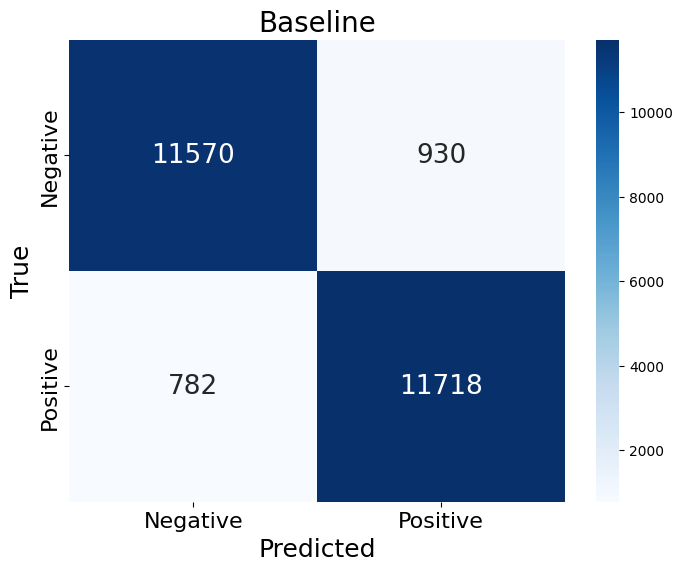

In [46]:
# Creating a confusion matrix
cm = confusion_matrix(scored_df1["true_label"], scored_df1["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 19},
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Baseline', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [47]:
# Plotting some examples of predictions (whole dataset)
def show_example_predictions(df, num_examples=10, num_tokens=False):
    indices = np.random.choice(df.index, min(num_examples, len(df)), replace=False)

    for idx in indices:
        review = df.loc[idx, "review"]
        true_label = "Positive" if df.loc[idx, "true_label"] == 1 else "Negative"
        pred_label = "Positive" if df.loc[idx, "predicted_label"] == 1 else "Negative"
        positive_score = df.loc[idx, "positive_score"]
        confidence = df.loc[idx, "confidence"]
        print(f"Index: {idx}") 
        print(f"Review (first 200 chars): {review[:200]}...")
        print(f"True Sentiment: {true_label}")
        print(f"Predicted Sentiment: {pred_label} (Confidence: {confidence:.4f})")
        print(f"Positive Score: {positive_score:.4f}")
        if num_tokens:
            number_tokens = df.loc[idx, "num_tokens"]
            print(f"Number of tokens: {number_tokens}")
        print("-" * 80)

show_example_predictions(scored_df1, num_examples=10)

Index: 21119
Review (first 200 chars): Maybe it was the excessive weight gain Seagal had put on. Or maybe it was the horrible acting of Wayans in an action flick. Or was it the total lack of chemistry between the two leading characters? Th...
True Sentiment: Negative
Predicted Sentiment: Negative (Confidence: 0.9978)
Positive Score: 0.0022
--------------------------------------------------------------------------------
Index: 5292
Review (first 200 chars): I've been waiting almost 25 years to see this hard to find horror thriller and I finally did since it's proper rebirth on DVD. Of course it didn't have the same impact on me as it would have if I had ...
True Sentiment: Positive
Predicted Sentiment: Positive (Confidence: 0.9979)
Positive Score: 0.9979
--------------------------------------------------------------------------------
Index: 1813
Review (first 200 chars): Barney is about "IMAGINATION" what you guys do not have if my preschooler never wanted to play pretend like they do i

In [51]:
# Focus on incorrect predictions
incorrect_df1 = scored_df1[scored_df1["predicted_label"] != scored_df1["true_label"]]
correct_df1 = scored_df1[scored_df1["predicted_label"] == scored_df1["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df1, num_examples = 20, num_tokens = True)

Index: 15514
Review (first 200 chars): It opens - and for half an hour, runs - like an educational programme on the Old Testament, although not without humour. The movie finally begins to grow wings when the biblical cant gets dropped. In ...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9849)
Positive Score: 0.9849
Number of tokens: 307
--------------------------------------------------------------------------------
Index: 12843
Review (first 200 chars): Don't worry when looking at the cover of the DVD, Sandra Bullock only appears at most 5 minutes in total in this cult classic. The entertainment value here is very high. To name but a few of the many ...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9767)
Positive Score: 0.9767
Number of tokens: 184
--------------------------------------------------------------------------------
Index: 3768
Review (first 200 chars): I've been a fan of Heaven's Gate since its first release. I've seen it a

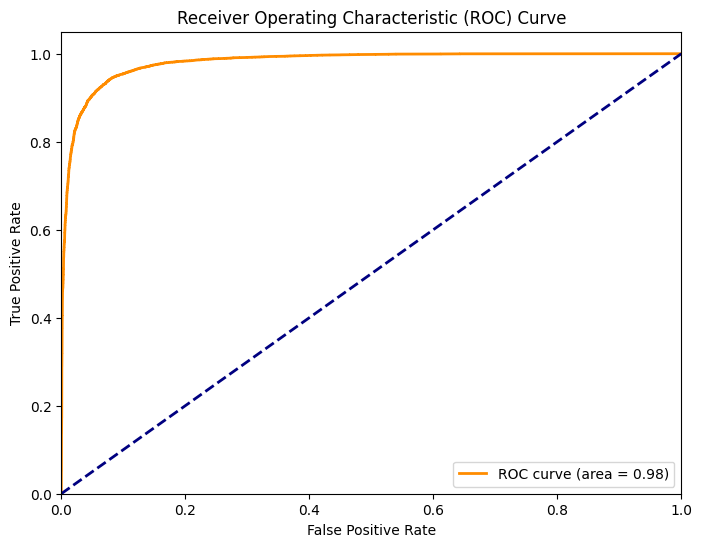

In [52]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Get true labels and predicted probabilities and predicted probabilities for the positive class
labels = scored_df1["true_label"].values
probs = scored_df1["positive_score"].values

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# PART II : Conducting a LIME analysis to improve the model

## LIME analysis on the results of the baseline DistilBERT model

In [53]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [54]:
# Creating an empty cache
torch.cuda.empty_cache()

lime_cache_file = "lime_cache.pkl"
try:
    lime_cache = joblib.load(lime_cache_file)
    print(f"Loaded {len(lime_cache)} cached explanations")
except:
    lime_cache = {}
    print("Created new LIME explanation cache")

Created new LIME explanation cache


In [55]:
# Function necessary in LIME explanation, to get the probabilities for the positive class
def predict_proba_lime(texts):
    # Ensuring the model is on CPU for LIME predictions
    model_cpu = model.to("cpu")
    
    # Processing inputs in smaller batches
    batch_size = 8
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # reducing max_length to save memory (e.g., 256 tokens)
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                         return_tensors="pt", max_length=256)
        
        with torch.no_grad():
            outputs = model_cpu(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.numpy())
    
    return np.vstack(all_probs) if len(all_probs) > 1 else all_probs[0]

In [56]:
# Defining the LIME explainer
class_names = ["Negative", "Positive"]
explainer = LimeTextExplainer(class_names=class_names, split_expression='\W+')

# Function to get or compute LIME explanation
def get_or_compute_explanation(idx, num_features=5):
    cache_key = f"{idx}_{num_features}"
    if cache_key in lime_cache:
        return lime_cache[cache_key]
    
    # We are getting the text from the scored dataframe
    text = scored_df1.loc[idx,'review']
    
    # Generating LIME explanation with reduced samples
    explanation = explainer.explain_instance(
        text,
        predict_proba_lime,
        num_features=min(num_features, len(text.split())),
        num_samples=500,  # reduced from default 5000 to save memory
        top_labels=2
    )
    
    # Cache the result
    lime_cache[cache_key] = explanation
    if len(lime_cache) % 5 == 0:  # Save cache periodically
        joblib.dump(lime_cache, lime_cache_file)
    
    return explanation

In [57]:
# Function to analyze a specific misclassified example
def analyze_classification(idx, num_features=5):
    model.to("cpu")
    torch.cuda.empty_cache()
    gc.collect()

    text = scored_df1.loc[idx, 'review']
    
    print(f"\n{'='*80}")
    print(f"ANALYZING THE EXAMPLE #{idx}")
    print(f"{'='*80}")
    show_example_predictions(scored_df1.loc[[idx]], num_examples=1)
    print("-" * 80)
   
    # Get explanation (from cache or compute new)
    explanation = get_or_compute_explanation(idx, num_features)

    # Analyze both classes to understand why the misclassification happened
    for label_id in [0, 1]: 
        label_name = class_names[label_id]
        print(f"\nFeature importance for class: {label_name}")
        
        feature_importance = explanation.as_list(label_id) # getting the words and their weights
      
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True) # sorting by absolute weight for better visualization

        # Text-based visualization instead of matplotlib
        print(f"Top words driving {label_name} prediction:")
        for word, weight in feature_importance[:10]:
            impact = "increasing" if weight > 0 else "decreasing"
            print(f"  • '{word}': {weight:.4f} ({impact} probability)")

    # Identifying words in context
    print("\nWords in context:")
    for word, _ in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:5]:
        # getting the context and highlighting the word in this context
        lower_text = text.lower()
        word_lower = word.lower()
        start_pos = lower_text.find(word_lower)
        if start_pos != -1:
            context_start = max(0, start_pos - 50)
            context_end = min(len(text), start_pos + len(word) + 50)
            context = text[context_start:context_end]
            
            highlighted = context.replace(word, f"**{word}**")
            print(f"  • Context: \"...{highlighted}...\"") 

    # Clearing memory again
    torch.cuda.empty_cache()
    gc.collect()
    
    return explanation

In [58]:
# Batch processing for misclassifications
def analyze_misclassifications_batch(num_examples=3, batch_size=2):
    # indices are selected from the incorrect classifications dataframe
    indices = np.random.choice(incorrect_df1.index, min(num_examples, len(incorrect_df1)), replace=False)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)  # analyze the example using the previous function
        
        # Clear memory after each batch
        model.to("cpu")
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Completed batch {i//batch_size + 1}/{(len(indices) + batch_size - 1)//batch_size}")


In [59]:
def analyze_confident_misclassifications(num_examples=3, batch_size=2):
    if incorrect_df1.empty:
        print("No misclassified examples found.")
        return

    # getting the top 100 most confident incorrect predictions and picking the most confident among them
    top_incorrect = incorrect_df1.sort_values(by="confidence", ascending=False).head(100)
    selected_indices = top_incorrect.index[:num_examples]

    # Analyzing in batches
    print(f"\n{'='*80}")
    print(f"ANALYZING MOST CONFIDENT MISCLASSIFICATIONS")
    print(f"{'='*80}")

    for i in range(0, len(selected_indices), batch_size):
        batch_indices = selected_indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)
        
        # clearing memory after each batch
        torch.cuda.empty_cache()
        gc.collect()

In [60]:
def analyze_misclassification_patterns(max_examples=20):
    if incorrect_df1.empty:
        print("No misclassified examples found.")
        return

    word_frequency = Counter()

    for idx in incorrect_df1.index[:max_examples]:
        text = incorrect_df1.loc[idx, 'review']
        words = set(text.lower().split())
        word_frequency.update(words)

    print("\nCommon words in misclassified examples:")
    for word, count in word_frequency.most_common(10):
        if len(word) > 2:
            print(f"'{word}': {count}")

    print("\nPotentially problematic words:")
    for word, count in word_frequency.most_common(50):
        if len(word) > 3 and count > max_examples / 3:
            examples = []
            for idx in incorrect_df1.index[:max_examples]:
                text = incorrect_df1.loc[idx, 'review'].lower()
                if word in text.split():
                    true_label = "Positive" if incorrect_df1.loc[idx, 'true_label'] == 1 else "Negative"
                    pred_label = "Positive" if incorrect_df1.loc[idx, 'predicted_label'] == 1 else "Negative"
                    examples.append((true_label, pred_label))
                    if len(examples) >= 3:
                        break
            if examples:
                print(f"'{word}': {count} occurrences - Examples: {examples}")


In [61]:
# Finally running the analysis
print("Starting optimized LIME analysis of misclassified examples...")
analyze_misclassifications_batch(3, batch_size=1)  # analyzing 3 random misclassifications, 1 at a time

print("\nAnalyzing patterns in misclassifications...")
analyze_misclassification_patterns(20)

print("\nAnalyzing the most confident misclassifications...")
analyze_confident_misclassifications(3, batch_size=1)  # analyzing 3 most confident misclassifications, 1 at a time

# Saving final cache
joblib.dump(lime_cache, lime_cache_file)
print(f"\nSaved {len(lime_cache)} explanations to cache")

Starting optimized LIME analysis of misclassified examples...

ANALYZING THE EXAMPLE #5612
Index: 5612
Review (first 200 chars): (Some spoilers included:)Although, many commentators have called this film surreal, the term fits poorly here. To quote from Encyclopedia Britannica's, surreal means:"Fantastic or incongruous imagery"...
True Sentiment: Positive
Predicted Sentiment: Negative (Confidence: 0.9972)
Positive Score: 0.0028
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Feature importance for class: Negative
Top words driving Negative prediction:
  • 'eateries': 0.0244 (increasing probability)
  • 'naivete': -0.0242 (decreasing probability)
  • 'lad': 0.0213 (increasing probability)
  • 'have': 0.0210 (increasing probability)
  • 'flaw': 0.0194 (increasing probability)

Feature importance for class: Positive
Top words driving Positive prediction:
  • 'eateries': -0.02

## Fine-tuning our DistilBERT model with a mitigated version of our data

In [62]:
# Preparing the data : mitigated version
# Following the LIME output, we'll try to soften strong words manually

def soften_sentiment(example):
    text = example["review"]
    softened = text
    strong_words = {
    # Positive → Neutral
    "masterpiece": "film",
    "excellent": "good",
    "great": "nice",
    "amazing": "decent",
    "incredible": "solid",
    "fantastic": "well-done",
    "outstanding": "notable",
    "brilliant": "smart",
    "phenomenal": "memorable",
    "superb": "respectable",
    "wonderful": "pleasant",
    "flawless": "very clean",
    "perfect": "well-executed",
    "best": "not bad",
    "terrific": "good",
    "loved": "liked",
    "love": "appreciate",
    "awesome": "pretty good",
    "must-watch": "worth checking out",
    "beautiful": "visually appealing",
    "touching": "emotionally engaging",
    "heartwarming": "pleasant",
    "enjoyed": "found interesting",
    "delightful": "nice",
    "spectacular": "visually impressive",

    # Negative → Neutral
    "terrible": "not good",
    "awful": "subpar",
    "horrible": "bad",
    "boring": "slow",
    "worst": "underwhelming",
    "disgusting": "unpleasant",
    "dreadful": "hard to watch",
    "pathetic": "weak",
    "hate": "dislike",
    "hated": "didn't like",
    "garbage": "poorly made",
    "trash": "low quality",
    "painful": "uncomfortable",
    "unwatchable": "difficult to follow",
    "nonsense": "confusing",
    "cringe": "awkward",
    "annoying": "irritating",
    "mess": "disorganized",
    "stupid": "not smart",
    "bad": "not good",
    "lame": "unimpressive",
    "dull": "unexciting",
    "forgettable": "not memorable",
    "pointless": "lacking purpose",
    "disappointing": "did not meet expectations"
}
    for word, replacement in strong_words.items():
        softened = softened.replace(word, replacement)
    return {"review_soft": softened, "review": text} # the 'review_soft' column will be used instead to train and evaluate the model
    
train_dataset = train_dataset.map(soften_sentiment)
eval_dataset = eval_dataset.map(soften_sentiment)
test_dataset = test_dataset.map(soften_sentiment) 

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [64]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# Tokenization using DistilBERT, with our function, but changing to review_soft column
train_tokenized = train_dataset.map(tokenize, batched=True, fn_kwargs={"type_review": "review_soft"})
eval_tokenized = eval_dataset.map(tokenize, batched=True, fn_kwargs={"type_review": "review_soft"})
test_tokenized = test_dataset.map(tokenize, batched=True, fn_kwargs={"type_review": "review_soft"})

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [66]:
# Setting the format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])

In [67]:
# Trainer initialization (same arguments as before)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,  
    compute_metrics=compute_metrics) 

In [68]:
# Fine-Tuning the DistilBERT
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Step,Training Loss,Validation Loss,Accuracy
500,0.340500,0.250676,0.902800
1000,0.260200,0.204992,0.918000
1500,0.212400,0.329894,0.908800
2000,0.136900,0.259648,0.924800
2500,0.128500,0.241319,0.926800


TrainOutput(global_step=2814, training_loss=0.20482075900665478, metrics={'train_runtime': 1525.2931, 'train_samples_per_second': 29.503, 'train_steps_per_second': 1.845, 'total_flos': 5961032939520000.0, 'train_loss': 0.20482075900665478, 'epoch': 2.0})

In [69]:
# Saving the model after training
model_save_path = "./imdb_sentiment_model_2"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Saving the training arguments using the to_json_string method
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model_2


In [70]:
# Creating the final scored dataframe
all_preds, all_scores, all_token_counts = test_predictions(model, test_tokenized)

all_texts_soft = test_dataset["review_soft"]

scored_df2 = pd.DataFrame({
    "review": all_texts,
    "review_soft" : all_texts_soft,
    "true_label": all_true_labels,
    "rating": all_ratings,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts, 
    }, index=test_df.index)

scored_df2["rating"] = scored_df2["rating"].astype(int)

# Adding a 'confidence' column
scored_df2["confidence"] = np.where(scored_df2["predicted_label"] == 1, scored_df2["positive_score"], 1 - scored_df2["positive_score"])

scored_df2.to_csv('predictions_full_results_2.csv', index=False)

np.save("preds2.npy", np.array(all_preds))
np.save("scores2.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

100%|██████████| 1563/1563 [03:15<00:00,  7.98it/s]


Predictions and scores saved.


In [71]:
# Computing metrics
accuracy = accuracy_score(scored_df2["true_label"], scored_df2["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df2["true_label"], scored_df2["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9318
Precision: 0.9243
Recall: 0.9407
F1 Score: 0.9324


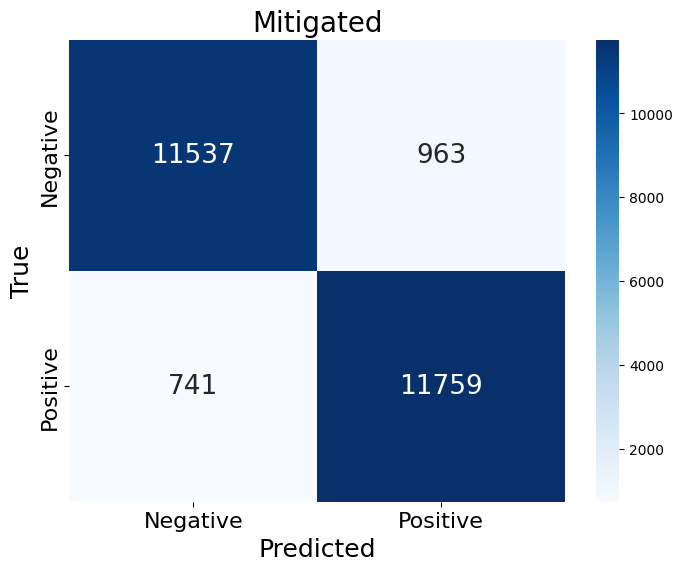

In [72]:
# Creating a confusion matrix
cm = confusion_matrix(scored_df2["true_label"], scored_df2["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 19},
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Mitigated', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [73]:
show_example_predictions(scored_df2, num_examples=10)

Index: 888
Review (first 200 chars): Easily one of the best Indian films ever. Granted, that's not saying much(I made this conclusion after a whopping 15 minutes of watching). But I can truly say that Fire is also one of the really beaut...
True Sentiment: Positive
Predicted Sentiment: Positive (Confidence: 0.9974)
Positive Score: 0.9974
--------------------------------------------------------------------------------
Index: 16509
Review (first 200 chars): "The Best Movie of the 90's" "The Welsh Trainspotting"....Aye, right! I went into this movie with pretty high expectations, and it was all downhill from there.This movie was supposed to be this archet...
True Sentiment: Negative
Predicted Sentiment: Negative (Confidence: 0.9968)
Positive Score: 0.0032
--------------------------------------------------------------------------------
Index: 6443
Review (first 200 chars): a great movie, with a rather unclear political message. it´s shot in a theatrical style, i.c. most of the action takes

In [75]:
# Focus on incorrect predictions
incorrect_df2 = scored_df2[scored_df2["predicted_label"] != scored_df2["true_label"]]
correct_df2 = scored_df2[scored_df2["predicted_label"] == scored_df2["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df2, num_examples = 20)

Index: 15355
Review (first 200 chars): Breaking Dawn starts in a Californian college as Professor Simon (associate producer Joe Morton) tells his students that they have to perform an intensive six week study of a mental patient in Cape St...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9962)
Positive Score: 0.9962
--------------------------------------------------------------------------------
Index: 16721
Review (first 200 chars): the usual disclaimer - I do not give 1 star ratings to movies which are harmless, bad, low budget and silly, although they may deserve it. These films are often funny, and get rated 2-4 based sheerly ...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9424)
Positive Score: 0.9424
--------------------------------------------------------------------------------
Index: 4198
Review (first 200 chars): Film about the failure of government and the selfishness of adults. Overwhelming impossibility of dealing with life 

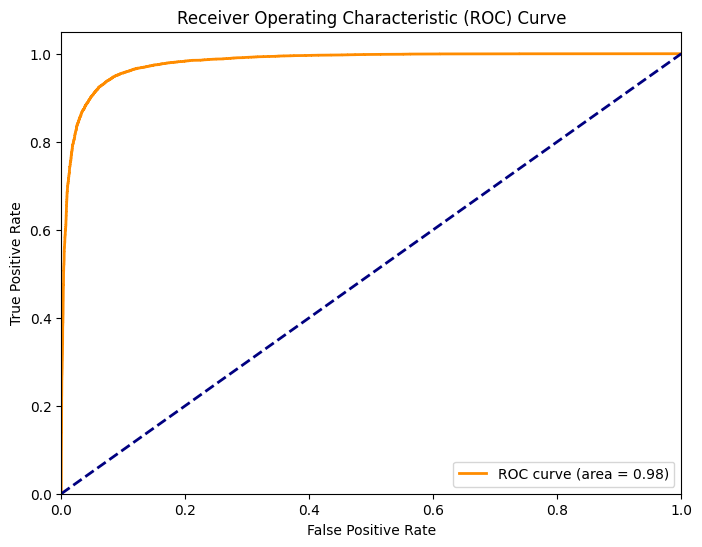

In [76]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

labels = scored_df2["true_label"].values
probs = scored_df2["positive_score"].values

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# PART III : The problem of long reviews

## Does truncation to the first 512 tokens during tokenization seem to lead to more misclassifications in general ?

We look at the baseline model results.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


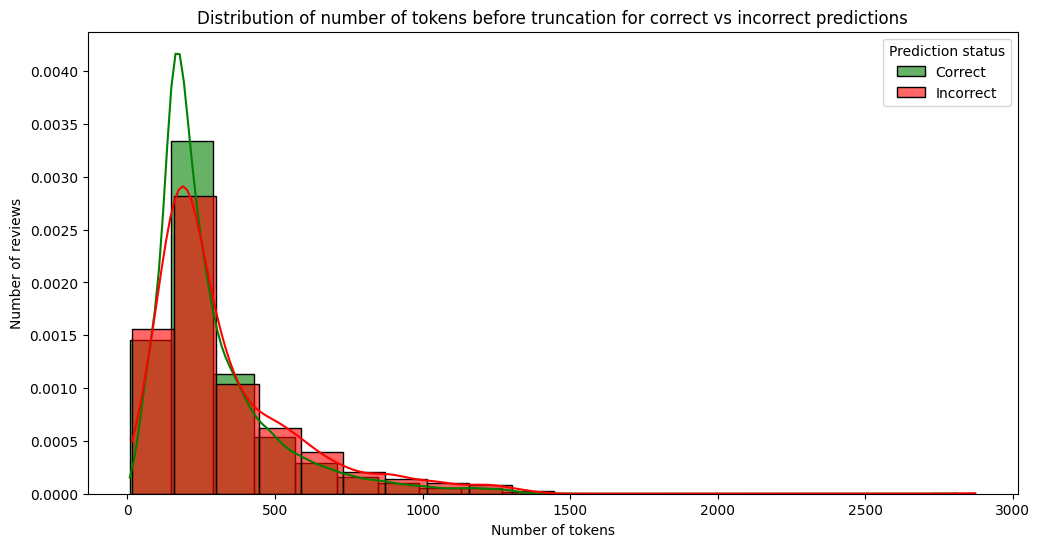

In [78]:
plt.figure(figsize=(12, 6))

# Correct tokens distribution
sns.histplot(correct_df1["num_tokens"], color='green', label='Correct', kde=True, stat="density", bins=20, alpha=0.6)
# Incorrect tokens distribution
sns.histplot(incorrect_df1["num_tokens"], color='red', label='Incorrect', kde=True, stat="density", bins=20, alpha=0.6)

plt.title("Distribution of number of tokens before truncation for correct vs incorrect predictions")
plt.xlabel("Number of tokens")
plt.ylabel("Number of reviews")
plt.legend(title="Prediction status")
plt.show()

In [86]:
# Then we calculate the proportions of incorrectly classified reviews among the truncated or non truncated during tokenization 
incorrect_over_510_proportion = len(
    scored_df1[(scored_df1["predicted_label"] != scored_df1["true_label"]) & (scored_df1["num_tokens"] > 510)]
) / len(scored_df1[scored_df1["num_tokens"] > 510])

incorrect_under_510_proportion = len(
    scored_df1[(scored_df1["predicted_label"] != scored_df1["true_label"]) & (scored_df1["num_tokens"] <= 510)]
) / len(scored_df1[scored_df1["num_tokens"] <= 510])

# Print the proportions
print(f"Proportion of incorrectly classified reviews with over 510 initial tokens: {incorrect_over_510_proportion:.4f}")
print(f"Proportion of incorrectly classified reviews with under 510 initial tokens: {incorrect_under_510_proportion:.4f}")

Proportion of incorrectly classified reviews with over 510 initial tokens: 0.1011
Proportion of incorrectly classified reviews with under 510 initial tokens: 0.0639


## Fine-tuning our DistilBERT model after applying a custom tokenization function to our datasets

In [87]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We build a custom tokenisation function following the results of Chi Sun et al. (2020)(https://arxiv.org/pdf/1905.05583) , where the reviews which are tokenized into a number of tokens superior to BERT's (DistilBERT in our case) limit (512, if we account for the two special tokens) are truncated so that only the first 128 and the last 382 tokens are kept, instead of keeping only the first 510 tokens.

In [88]:
# Custom tokenization function
def tokenize_custom(batch):
    # First we tokenize the text without padding or special tokens
    tokenized = tokenizer(batch["review"], padding=False, truncation=False, add_special_tokens=False)

    # Then we compute the number of tokens for each review before truncation
    num_tokens = [len(t) for t in tokenized["input_ids"]]

    truncated_input_ids = []
    for t in tokenized["input_ids"]:
        if len(t) > 510:
            # keeping the first 128 and last 382 tokens if the tokenized review is too long
            truncated_input_ids.append(t[:128] + t[-382:])
        else:
            # or keep it identical if not
            truncated_input_ids.append(t)
    
    # Manually padding to 512 tokens
    max_length = 510
    padded_input_ids = []
    attention_mask = []
    for t in truncated_input_ids:
        padding_length = max_length - len(t)
        padded_input_ids.append(t + [tokenizer.pad_token_id] * padding_length)
        attention_mask.append([1] * len(t) + [0] * padding_length)

    # Manually adding special tokens (for DistilBERT, the special tokens are [CLS] and [SEP] at the start and end of the sequence)
    cls_token_id = tokenizer.cls_token_id
    sep_token_id = tokenizer.sep_token_id
    final_input_ids = []
    final_attention_mask = []
    for i in range(len(padded_input_ids)):
        final_input_ids.append([cls_token_id] + padded_input_ids[i] + [sep_token_id])
        final_attention_mask.append([1] + attention_mask[i] + [1])  # 1 for actual tokens and 1 for [CLS] and [SEP]

    # Returning the final batch with `input_ids`, `attention_mask`, and `num_tokens`
    final_batch = {
        "input_ids": torch.tensor(final_input_ids),
        "attention_mask": torch.tensor(final_attention_mask),
        "label": torch.tensor(batch["label"]), 
        "num_tokens": torch.tensor(num_tokens)
    }

    return final_batch

In [89]:
train_tokenized = train_dataset.map(tokenize_custom, batched=True)
eval_tokenized = eval_dataset.map(tokenize_custom, batched=True)
test_tokenized = test_dataset.map(tokenize_custom, batched=True)

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [90]:
# Setting the format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])

In [92]:
# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics) 

/tmp/ipykernel_31/1828400361.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [93]:
# Fine-Tuning the DistilBERT
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Step,Training Loss,Validation Loss,Accuracy
500,0.321400,0.255031,0.895200
1000,0.252200,0.198680,0.924400
1500,0.199900,0.288750,0.925200
2000,0.126600,0.239015,0.930400
2500,0.115600,0.226204,0.933600


TrainOutput(global_step=2814, training_loss=0.1925737059700972, metrics={'train_runtime': 1535.4014, 'train_samples_per_second': 29.308, 'train_steps_per_second': 1.833, 'total_flos': 5961032939520000.0, 'train_loss': 0.1925737059700972, 'epoch': 2.0})

In [94]:
# Saving the model after training
model_save_path = "./imdb_sentiment_model_3"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Saving training arguments using the to_json_string method
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model_3


In [95]:
# Creating the final scored dataframe
all_preds, all_scores, all_token_counts = test_predictions(model, test_tokenized)

scored_df3 = pd.DataFrame({
    "review": all_texts,
    "true_label": all_true_labels,
    "rating": all_ratings,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts,
    }, index=test_df.index)

scored_df3["rating"] = scored_df3["rating"].astype(int)

# Adding a 'confidence' column
scored_df3["confidence"] = np.where(scored_df3["predicted_label"] == 1, scored_df3["positive_score"], 1 - scored_df3["positive_score"])

scored_df3.to_csv('predictions_full_results_3.csv', index=False)

np.save("preds3.npy", np.array(all_preds))
np.save("scores3.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

100%|██████████| 1563/1563 [03:16<00:00,  7.96it/s]


Predictions and scores saved.


In [97]:
# Computing metrics
accuracy = accuracy_score(scored_df3["true_label"], scored_df3["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df3["true_label"], scored_df3["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9375
Precision: 0.9348
Recall: 0.9406
F1 Score: 0.9377


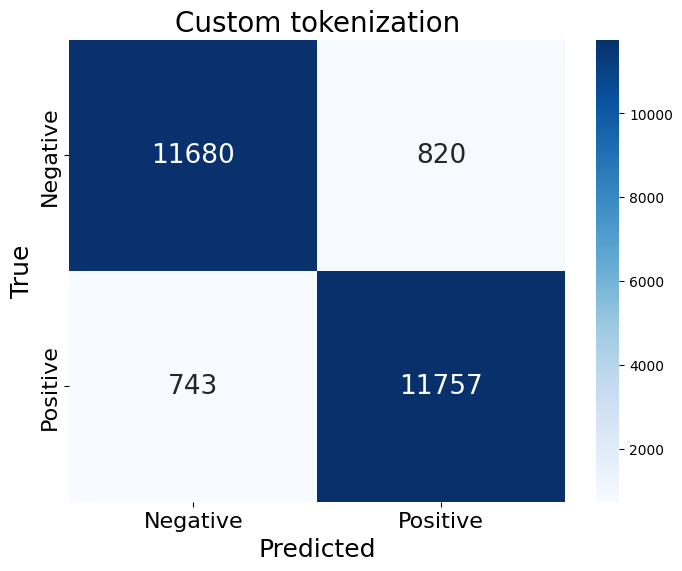

In [98]:
# Creating a confusion matrix
cm = confusion_matrix(scored_df3["true_label"], scored_df3["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 19},
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Custom tokenization', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [99]:
# Focus on incorrect predictions
incorrect_df3 = scored_df3[scored_df3["predicted_label"] != scored_df3["true_label"]]
correct_df3 = scored_df3[scored_df3["predicted_label"] == scored_df3["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df3, num_examples = 20, num_tokens = True)

Index: 19267
Review (first 200 chars): This is said to be the first Polish western and is written and directed by Piotr Uklanski. Known in the U.S. as DEAD MAN'S BOUNTY, this film uses some strange visuals to tell a story that is short on ...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9899)
Positive Score: 0.9899
Number of tokens: 314
--------------------------------------------------------------------------------
Index: 19274
Review (first 200 chars): I saw this film while I was in France and I must say that it confused me. It is a story of a jewel thief and a young singer who each end up in Morocco at the same time, run into one another and form a...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.8607)
Positive Score: 0.8607
Number of tokens: 161
--------------------------------------------------------------------------------
Index: 5435
Review (first 200 chars): The animation quality here is decidedly below par IMO, regardless of the

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


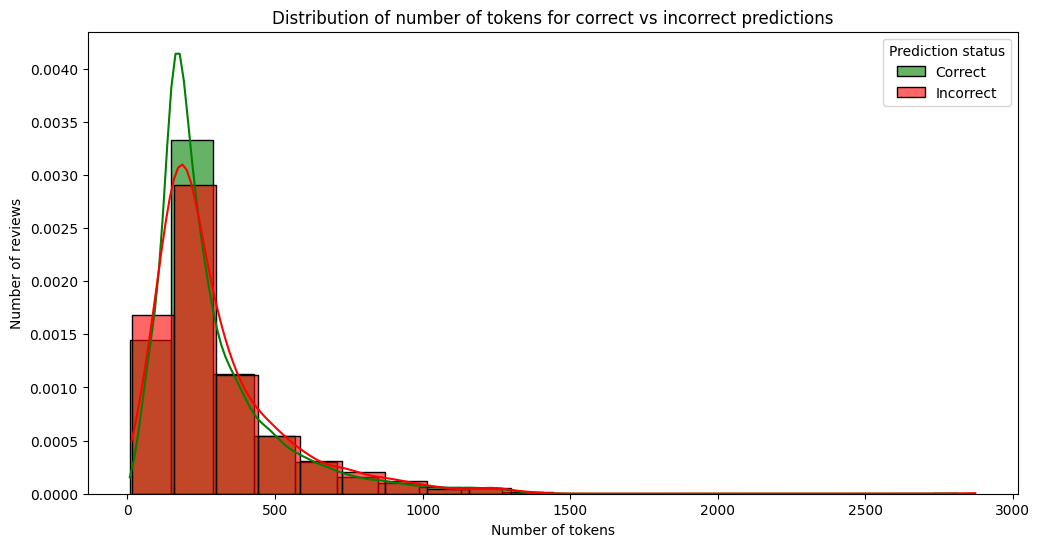

In [100]:
plt.figure(figsize=(12, 6))

# Correct tokens distribution
sns.histplot(correct_df3["num_tokens"], color='green', label='Correct', kde=True, stat="density", bins=20, alpha=0.6)
# Incorrect tokens distribution
sns.histplot(incorrect_df3["num_tokens"], color='red', label='Incorrect', kde=True, stat="density", bins=20, alpha=0.6)

plt.title("Distribution of number of tokens for correct vs incorrect predictions")
plt.xlabel("Number of tokens")
plt.ylabel("Number of reviews")
plt.legend(title="Prediction status")
plt.show()

In [101]:
# As for the baseline results we calculate the proportions of incorrectly classified reviews among the truncated or non truncated during tokenization 
incorrect_over_510_proportion_update = len(
    scored_df3[(scored_df3["predicted_label"] != scored_df3["true_label"]) & (scored_df3["num_tokens"] > 510)]
) / len(scored_df3[scored_df3["num_tokens"] > 510])

incorrect_under_510_proportion_update = len(
    scored_df3[(scored_df3["predicted_label"] != scored_df3["true_label"]) & (scored_df3["num_tokens"] <= 510)]
) / len(scored_df3[scored_df3["num_tokens"] <= 510])

# Print the proportions
print(f"Proportion of incorrectly classified reviews with over 510 initial tokens: {incorrect_over_510_proportion_update:.4f}")
print(f"Proportion of incorrectly classified reviews with under 510 initial tokens: {incorrect_under_510_proportion_update:.4f}")

Proportion of incorrectly classified reviews with over 510 initial tokens: 0.0706
Proportion of incorrectly classified reviews with under 510 initial tokens: 0.0614


# PART IV : Mixed model : mitigated + custom tokenization

In [111]:
# Rename columns in the mitigated datasets to match with the token_custom function
train_dataset = train_dataset.rename_column("review", "pre_review")
train_dataset = train_dataset.rename_column("review_soft", "review")

eval_dataset = eval_dataset.rename_column("review", "pre_review")
eval_dataset = eval_dataset.rename_column("review_soft", "review")

test_dataset = test_dataset.rename_column("review", "pre_review")
test_dataset = test_dataset.rename_column("review_soft", "review")

In [112]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
train_tokenized = train_dataset.map(tokenize_custom, batched=True)
eval_tokenized = eval_dataset.map(tokenize_custom, batched=True)
test_tokenized = test_dataset.map(tokenize_custom, batched=True)

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [115]:
# Setting the format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])

In [116]:
# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics) 

/tmp/ipykernel_31/1828400361.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [117]:
# Fine-Tuning the DistilBERT
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Step,Training Loss,Validation Loss,Accuracy
500,0.336000,0.258300,0.898000
1000,0.258500,0.210601,0.921600
1500,0.210900,0.365697,0.920400
2000,0.145600,0.274149,0.928000
2500,0.127500,0.233701,0.936400


TrainOutput(global_step=2814, training_loss=0.20448122654896556, metrics={'train_runtime': 1540.6287, 'train_samples_per_second': 29.209, 'train_steps_per_second': 1.827, 'total_flos': 5961032939520000.0, 'train_loss': 0.20448122654896556, 'epoch': 2.0})

In [118]:
# Saving the model after training
model_save_path = "./imdb_sentiment_model_4"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Saving training arguments using the to_json_string method
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model_4


In [119]:
# Creating the final scored dataframe
all_preds, all_scores, all_token_counts = test_predictions(model, test_tokenized)

scored_df4 = pd.DataFrame({
    "review": all_texts,
    "review_soft" : all_texts_soft,
    "true_label": all_true_labels,
    "rating": all_ratings,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts,
    }, index=test_df.index)

scored_df4["rating"] = scored_df4["rating"].astype(int)

# Adding a 'confidence' column
scored_df4["confidence"] = np.where(scored_df4["predicted_label"] == 1, scored_df4["positive_score"], 1 - scored_df4["positive_score"])

scored_df4.to_csv('predictions_full_results_4.csv', index=False)

np.save("preds4.npy", np.array(all_preds))
np.save("scores4.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

100%|██████████| 1563/1563 [03:16<00:00,  7.96it/s]


Predictions and scores saved.


In [120]:
# Computing metrics
accuracy = accuracy_score(scored_df4["true_label"], scored_df4["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df4["true_label"], scored_df4["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9342
Precision: 0.9229
Recall: 0.9476
F1 Score: 0.9351


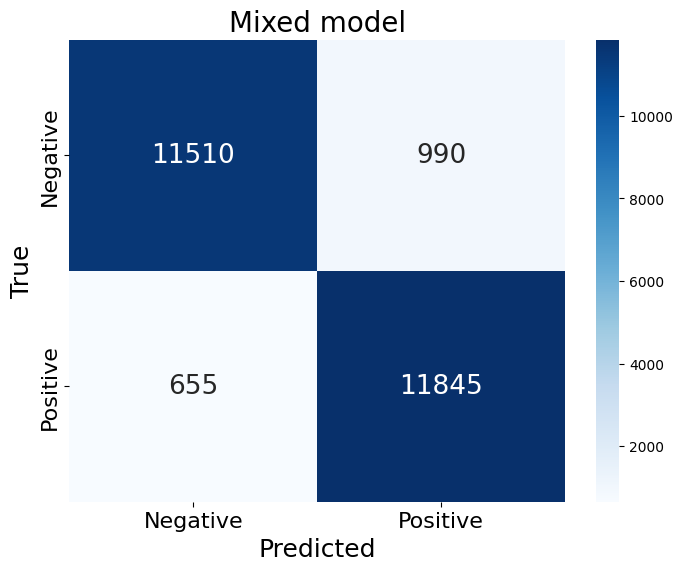

In [121]:
# Creating a confusion matrix
cm = confusion_matrix(scored_df4["true_label"], scored_df4["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 19},
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Mixed model', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [122]:
# Focus on incorrect predictions
incorrect_df4 = scored_df4[scored_df4["predicted_label"] != scored_df4["true_label"]]
correct_df4 = scored_df4[scored_df4["predicted_label"] == scored_df4["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df4, num_examples = 20, num_tokens = True)

Index: 11423
Review (first 200 chars): It's too bad iameracing wants to deny the reality of Faulkner's and Clarence Brown's purpose in the creating of the story and film of "Intruder In The Dust". I suppose the burden of a history of racis...
True Sentiment: Positive
Predicted Sentiment: Negative (Confidence: 0.9954)
Positive Score: 0.0046
Number of tokens: 795
--------------------------------------------------------------------------------
Index: 10789
Review (first 200 chars): Christine Lahti (Sandy Dunlap) and Mary Tyler Moore (Holly Davis) worked well with soapish material, Ted Danson did his best with a thankless role of Chip Davis The premise of this that the two ladies...
True Sentiment: Positive
Predicted Sentiment: Negative (Confidence: 0.9888)
Positive Score: 0.0112
Number of tokens: 229
--------------------------------------------------------------------------------
Index: 23158
Review (first 200 chars): This film is all right, fairly silly and to be taken lightly. But what 

In [123]:
# As for the baseline results we calculate the proportions of incorrectly classified reviews among the truncated or non truncated during tokenization 
incorrect_over_510_proportion_update_mix = len(
    scored_df4[(scored_df4["predicted_label"] != scored_df4["true_label"]) & (scored_df4["num_tokens"] > 510)]
) / len(scored_df4[scored_df4["num_tokens"] > 510])

incorrect_under_510_proportion_update_mix = len(
    scored_df4[(scored_df4["predicted_label"] != scored_df4["true_label"]) & (scored_df4["num_tokens"] <= 510)]
) / len(scored_df4[scored_df4["num_tokens"] <= 510])

# Print the proportions
print(f"Proportion of incorrectly classified reviews with over 510 initial tokens: {incorrect_over_510_proportion_update_mix:.4f}")
print(f"Proportion of incorrectly classified reviews with under 510 initial tokens: {incorrect_under_510_proportion_update_mix:.4f}")

Proportion of incorrectly classified reviews with over 510 initial tokens: 0.0819
Proportion of incorrectly classified reviews with under 510 initial tokens: 0.0635


# Complements on results for discussion
We look at the corresponding ratings for each review (III - Custom tokenization model results), correctly or incorrectly classified, and show that misclassified reviews are more often the ones associated with the most neutral ratings (4 or 7).

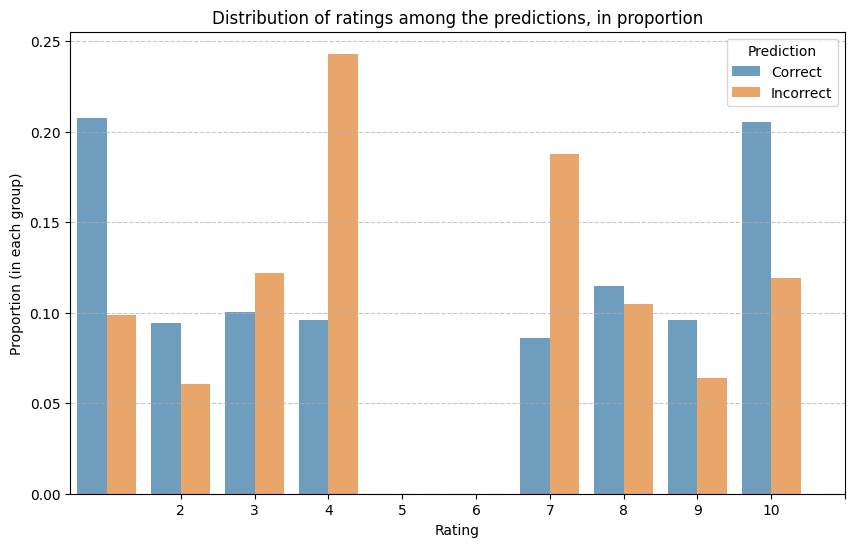

In [103]:
# Distribution of review ratings for correctly and incorrectly classified reviews

correct_counts = correct_df3["rating"].value_counts(normalize=True).sort_index()
incorrect_counts = incorrect_df3["rating"].value_counts(normalize=True).sort_index()

plot_df = pd.DataFrame({
    "rating": range(1, 11),
    "Correct": correct_counts.reindex(range(1, 11), fill_value=0),
    "Incorrect": incorrect_counts.reindex(range(1, 11), fill_value=0)
})

plot_df = plot_df.melt(id_vars="rating", value_vars=["Correct", "Incorrect"], var_name="Prediction", value_name="Proportion")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="rating",
    y="Proportion",
    hue="Prediction",
    alpha=0.7
)

plt.xlabel("Rating")
plt.ylabel("Proportion (in each group)")
plt.title("Distribution of ratings among the predictions, in proportion")
plt.xticks(ticks=range(1, 11))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Prediction")
plt.show()


In [108]:
# to ensure full reviews are shown
pd.set_option('display.max_colwidth', None)

# We print some misclassified full reviews with rating 4 or 7
examples = incorrect_df3[incorrect_df3["rating"].isin([4, 7])]
examples.head()

,review,true_label,rating,predicted_label,positive_score,num_tokens,confidence
8614,"This film is essentially for those who have had little or no introduction to hip-hop, specifically turntableism, as was the case with the director before he started this film. It was cool to have it focus on the bay more than expected, because NY is always getting all the credit, but comin from the bay the Q-Bert worship is a little out of control. This film didn't introduce anything new to me, but it did change my opinion in that going into it I was sketchy about the prospect of giving the tables the distinction of being a bona fide instrument. This film ought to convince anyone that it's right up there with the viola and clavichord.",1,7,0,0.320756,142,0.679244
13338,"What we know of Caravaggio suggests a strutting brawler with a healthy sense of entitlement who lived amongst whores and thieves and hustlers and put them on canvas. His works' themes were sex, death, redemption, above all, finding the sacred within the profane. He lived at a time where homosexuality carried a death sentence and political intrigue normally involved fatalities in a society defined by the maxim ""strangling the boy for the purity of his scream"".You can't fault Derek Jarman for his cinematography, nor his recreations of Caravaggio's paintings and you certainly can't accuse the man of shying away from the homosexuality. But frankly, Jarman never strays beyond 80s caricature. Italian patronage becomes the 80s London art scene complete with pretty waiters and calculators. Sean Bean is a sexy bit of Northern rough oiling his motorbike. Tilda Swinton performs a transformation worthy of a Mills and Boons (""Why, Miss Lena, without that gypsy headscarf, you're beautiful...""). Jarman provides Caravaggio with a particularly trite motive for the murder which left him exiled.This could have been a visually stunning treatment of a man whose life was dangerous, exciting, violent and decadent but who nonetheless elevated the lives of ordinary people to the status of Renaissance masterpieces, looked on by Emperors and Kings. Instead, what you get is Pierre et Gilles do Italy. The pretty bodies of young boys are shown to perfection, but never the men who inhabit them. Jarman appears to satirise the London art scene, showing it shallow and pretentious. To use Caravaggio and Renaissance Italy to make the point is to use a silk purse to make a pig's ear. In fairness, this film remains visually stunning, but ultimately as two dimensional as the paintings it describes.",0,4,1,0.976478,389,0.976478
14415,"Don't get me wrong. I've got a considerable soft spot for the works of Charles Band, both as producer and director. But you've got to raise an eyebrow when the man who was willing to put his name to ""Dollman Vs The Demonic Toys"" sticks a pseudonym on anything. As a bit of bad-movie fun, ""Head Of The Family"" is rather lacking, although it is better acted than you might expect. Jacqueline Lovell is a definite talent who deserves better than these kinds of movies. J.W. Perra is also quite funny as the titular monster, though for such a superintelligent being he does get hoodwinked quite easily. Y'know, I'm nitpicking because the rest of the movie is so sharp and witty of course....And having a lead character called Lance Bogan? Nice one guys. We didn't know you Americans knew that piece of slang!",0,4,1,0.844880,195,0.844880
15465,"Saw this movie at a Saturday matinée with a friend. Theater was about 70% full.Although there are quite a few funny lines, it is more of a drama/suspense with humor sprinkled on top. Robin Williams gives a decent performance as does Laura Linney. Being a Daily Show fan, Lewis Black is pretty good in this. Christopher Walken gives a good performance also. The movie starts out slow and remains that way for about the first thirty minutes, then the suspense part kicks in and starts keeping you a little on edge throughout the rest of the movie. Suspense in a 